<a href="https://colab.research.google.com/github/ShivaKondapalli/Invariance/blob/master/FlowerMapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning in Pytorch using the Custom Dataset class. 

In [0]:
# Install Pytorch, a bit in involved 

from os.path import exists 
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

In [1]:
# import a few important packages to check their versions
# if Pillow isn't >= 5.3, click on Runitme, Restart Runtime and run this agian.

import torch 
import torchvision 
import numpy as np 
import PIL

print(torch.__version__)
print(torchvision.__version__)
print(np.__version__)
print(PIL.PILLOW_VERSION)

1.0.0
0.2.1
1.14.6
5.4.1


In [2]:
# sanity check for GPU 


train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('Bummer!  Training on CPU ...')
else:
    print('You are good to go!  Training on GPU ...')

You are good to go!  Training on GPU ...


In [0]:
# create device to move your Pytorch objects.

device  = torch.device('cuda:0' if torch.cuda.is_available() else 'cuda:1')


In [0]:
# mount your drive to get data 

from google.colab import drive

drive.mount('/content/gdrive')

In [0]:
# extract your data directory from you mounted drive

import zipfile
zip_ref = zipfile.ZipFile('/content/gdrive/My Drive/data.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [0]:
import torch
from torchvision import transforms
import torch.nn as nn
import os
from PIL import Image
from torch.utils.data import Dataset
import torch.nn.functional as F
import numpy as np
from torchvision import models
from torch.optim import lr_scheduler
from torch import optim
import json
from torch.utils.data.sampler import SubsetRandomSampler
import scipy.io
import torchvision
import copy
import time
import sys
torch.manual_seed(0)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [0]:
data_dir_path = 'data/images/'
labels_path = 'data/imagelabels.mat'
class_label_path = 'data/new_class_label_map'

data_transforms = {
        'train': transforms.Compose([
            transforms.RandomRotation(45),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ]),
        'valid': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ]),
    }

In [0]:
class MyDataset(Dataset):
    def __init__(self, image_labels, data_dir, transform=None):
        """

        :param image_labels_path: path to our labels
        :param root_dir: the directory which houses our images
        :param transform: apply any transform on our sample
        """

        self.image_labels = image_labels
        self.root_dir = data_dir
        self.transform = transform

    def __len__(self):
        label_dict = scipy.io.loadmat(self.image_labels)
        return len(label_dict['labels'][0])

    def __getitem__(self, idx):
        image_path_list = sorted([os.path.join(self.root_dir, filename) for filename in os.listdir(self.root_dir)])
        image = Image.open(image_path_list[idx])

        label_dict = scipy.io.loadmat(self.image_labels)
        label_list = label_dict['labels'][0]

        label_list[:] = [i - 1 for i in label_list]
        label = label_list[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


image_datasets = {x: MyDataset(image_labels=labels_path,
                                  data_dir=data_dir_path,
                               transform=data_transforms[x]) for x in ['train', 'valid', 'test']}

In [12]:
def get_train_valid_split(dataset, shuffle=True, first_split=0.8, second_split=0.9, random_seed=1):
    """

    :param dataset: dataset
    :param shuffle: shuffles the indices so random elements from our data find themselves in our splits.
    :param first_split: this is for train
    :param second_split: for validation
    :param random_seed: for test
    :return: train, validation and test loaders
    """
    dataset_size = len(dataset)  # get any, we just need the length, say its n
    indices = list(range(dataset_size))  # 0 though n-1.
    split1 = int(np.floor(first_split * dataset_size))
    split2 = int(np.floor(second_split * dataset_size))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx = indices[:split1]
    val_idx = indices[split1:split2]
    test_idx = indices[split2:]

    samplers = {'train': SubsetRandomSampler(train_idx), 'valid': SubsetRandomSampler(val_idx),
                'test': SubsetRandomSampler(test_idx)}

    return samplers


samplers = get_train_valid_split(image_datasets['train']) # any key works 

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, sampler=samplers[x]) for x in
                  ['train', 'valid', 'test']}


dataset_size ={x : len(samplers[x]) for x in ['train', 'valid', 'test']}
print(dataset_size)

{'train': 6551, 'valid': 819, 'test': 819}


In [0]:
def get_class_label_map(path):
    """the class number to the flower name dictionary"""

    with open(path) as f:
        data = json.load(f)

    return data


def imshow(image, ax=None, title=None):
    """to visuliaze any image passed to it"""

    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)

    if isinstance(image, np.ndarray):
        image = image.transpose((1, 2, 0))
    elif isinstance(image, torch.Tensor):
        image = image.numpy().transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)

    ax.imshow(image)

    return ax


def get_loaders(dataloaders, num_images, nrow, key='train'):
    """purpose of this function is to show how train transforms augment our training data"""

    imgs, lbls = next(iter(dataloaders[key]))
    imgs_lst = [imgs[i] for i in range(num_images)]
    out = torchvision.utils.make_grid(imgs_lst, nrow=nrow)
    lbls_lst = [lbls[i].item() for i in range(num_images)]

    data = get_class_label_map(class_label_path)

    data = {int(k): v for k, v in data.items()}

    flowers = []

    for item in lbls_lst:
        if item in data:
            flowers.append(data[item])

    return out, flowers

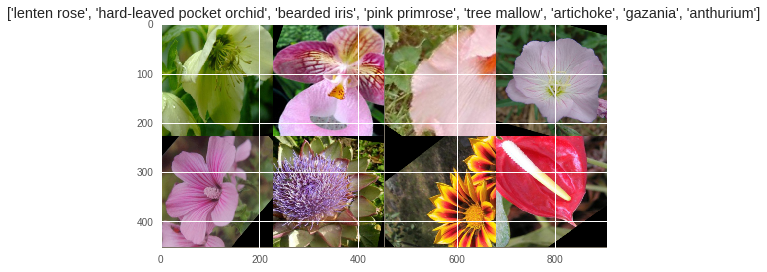

In [14]:
# print out a few flowers and see their names to 
# see how our train transforms augment out flowers.

imgs, names = get_loaders(dataloaders, 8, 4)
imshow(imgs, title=names)
plt.show()

In [0]:
class Neural(nn.Module):

    def __init__(self, input_size, hidden_layers, output_size, drop=0.5):

        super(Neural, self).__init__()  # inherits the __init__ method on the parent class Module.

        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])

        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])

        self.hidden_layers.extend(nn.ModuleList([nn.Linear(h1, h2) for h1, h2 in layer_sizes]))

        self.output = nn.Linear(hidden_layers[-1], output_size)
        self.dropout = nn.Dropout(p=drop)

    def forward(self, x):

        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            x = self.dropout(x)

        x = self.output(x)

        return F.log_softmax(x, dim=1)

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=3, device=device):

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('{}/{}'.format(epoch + 1, num_epochs))
        print('-' * 50)

        # each epoch has a train and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for images, labels in dataloaders[phase]:

                # convert ByteTensor to LongTensor
                labels = labels.type(torch.LongTensor)

                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()

                # when evaluates to true tracks history, else compute only forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    logps = model.forward(images)
                    _, preds = logps.max(dim=1)
                    # torch.exp(_) would gives back probs.
                    loss = criterion(logps, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * images.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_size[phase]
            epoch_acc = running_corrects.double() / dataset_size[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

In [0]:
model = models.vgg19(pretrained=True)

classifier = Neural(25088, [8000], 102, drop=0.6)

for param in model.parameters():
    param.requires_grad = False

model.classifier = classifier

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

print(classifier)

# print(model.classifier.hidden_layers)
# print(model.classifier.hidden_layers[0].in_features)
# print(model.classifier.hidden_layers[0].weight.size()) # 8000 * 25088
# print(model.classifier.hidden_layers[0].out_features)

In [18]:
num_epochs = 20

model.to(device)
model = train_model(model=model, criterion=criterion, optimizer=optimizer, scheduler=scheduler,
                num_epochs=num_epochs, device=device)

1/20
--------------------------------------------------
train Loss: 2.6750 Acc: 0.3943
valid Loss: 0.9758 Acc: 0.7595

2/20
--------------------------------------------------
train Loss: 1.3501 Acc: 0.6552
valid Loss: 0.7161 Acc: 0.7985

3/20
--------------------------------------------------
train Loss: 1.0271 Acc: 0.7286
valid Loss: 0.5448 Acc: 0.8425

4/20
--------------------------------------------------
train Loss: 0.7988 Acc: 0.7823
valid Loss: 0.4607 Acc: 0.8767

5/20
--------------------------------------------------
train Loss: 0.7363 Acc: 0.8054
valid Loss: 0.4443 Acc: 0.8791

6/20
--------------------------------------------------
train Loss: 0.7128 Acc: 0.8145
valid Loss: 0.4225 Acc: 0.8816

7/20
--------------------------------------------------
train Loss: 0.6903 Acc: 0.8206
valid Loss: 0.4223 Acc: 0.8803

8/20
--------------------------------------------------
train Loss: 0.6935 Acc: 0.8154
valid Loss: 0.4201 Acc: 0.8840

9/20
-------------------------------------------

In [0]:
# save model in our drive so that we can load and predict later

checkpoint = {'arch': 'vgg19', 'state_dict': model.state_dict(),
              'input': 25088, 'output': 102,'hidden_layers': [each.out_features for each in classifier.hidden_layers]}
  
path = "/content/gdrive/My Drive/classifier.pth"
torch.save(checkpoint, path)

In [20]:
def load_model(filepath):
  
    checkpoint = torch.load(filepath)

    if checkpoint['arch'] == 'vgg19':
        model = models.vgg19(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

    else:
        print('Please load the correct pre_trained architecture')
        sys.exit()

    classifier = Neural(checkpoint['input'], checkpoint['hidden_layers'], checkpoint['output'])

    model.classifier = classifier

    model.load_state_dict(checkpoint['state_dict'])

    return model
  
new_model = load_model(path)
new_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [21]:
# Let us calculate our test_loss and test_accuracy 

def calc_acc(model, data='test', device='cpu'):

    test_loss = 0
    test_acc = 0

    for inputs, labels in dataloaders[data]:
      
      model.to(device)
      model.eval()
      inputs, labels = inputs.to(device), labels.to(device)
      labels = labels.type(torch.LongTensor)  

    with torch.no_grad():
      
      logps = model.forward(inputs)  # batch_size * number of classes
      loss = criterion(logps, labels)  # computes loss for the current batch.

      logprobs, preds = logps.max(dim=1)
      matches = (preds == labels)

      test_loss += loss.item()
      test_acc += matches.type(torch.FloatTensor).mean()

    return test_loss, test_acc

test_loss, test_acc = calc_acc(new_model, 'test')
print(test_loss)
print(test_acc)

0.3388974368572235
tensor(0.9020)


In [0]:
def predict(loader, data, model, idx):
  dataloader = loader[data]
  imgs, lbls = next(iter(dataloader))
  imgs, lbls = imgs.cpu(), lbls.cpu()
  img, lbl = imgs[idx], lbls[idx].item()

  model.eval()

  probs = torch.exp(model.forward(img.unsqueeze(0)))
  top_5_probs, top_5_lbls = probs.topk(5)

  top_5_probs = top_5_probs.detach().numpy().tolist()[0]
  top_5_lbls = top_5_lbls.detach().numpy().tolist()[0]
    
  print(top_5_probs)
  print(top_5_lbls)

  class_label_map = get_class_label_map(class_label_path)
  class_label_map = {int(k): v for k, v in class_label_map.items()}

  true_title_name = class_label_map[lbl]

  pred_flower_names = [class_label_map[key] for key in top_5_lbls]
    
  print(pred_flower_names)

  return img, top_5_probs, true_title_name, pred_flower_names

[0.9574679732322693, 0.012494933791458607, 0.009464825503528118, 0.005448734853416681, 0.004339667037129402]
[30, 72, 36, 42, 90]
['carnation', 'water lily', 'cape flower', 'sword lily', 'hippeastrum ']


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


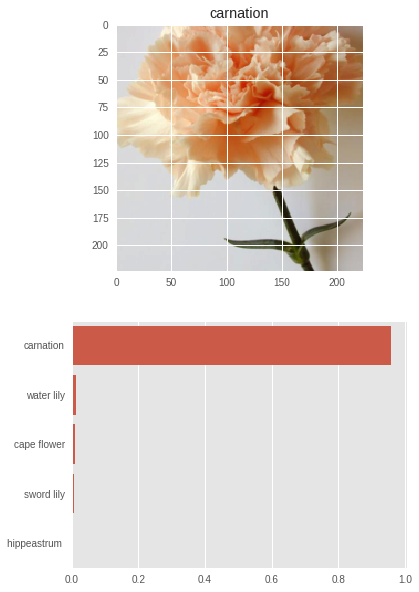

In [29]:
def plt_solution(loader, data, model, idx):
    plt.figure(figsize=(6, 10))
    ax = plt.subplot(2, 1, 1)

    img, top_5_probs, true_title_name, pred_flower_names = predict(loader, data, model, idx)

    imshow(img, ax, title=true_title_name)

    # # Plot bar chart
    plt.subplot(2, 1, 2)
    sns.barplot(x=top_5_probs, y=pred_flower_names, color=sns.color_palette()[0])
    plt.show()
    
plt_solution(loader = dataloaders, data='test', model=new_model, idx=27)